## Clifford Attractor
[Lázaro Alonso ](https://lazarusa.github.io/Webpage/index.html)
___

A [Clifford Attractor](http://paulbourke.net/fractals/clifford/) is a [strange attractor](https://en.wikipedia.org/wiki/Attractor#Strange_attractor) defined by two iterative equations that determine the $x,y$ locations of discrete steps in the path of a particle across a 2D space, given a starting point $(x_0,y_0)$ and the values of four parameters $(a,b,c,d)$:

\begin{equation}
x_{n +1} = \sin(a y_{n}) + c \cos(a x_{n})\\
y_{n +1} = \sin(b x_{n}) + d \cos(b y_{n})
\end{equation}
At each time step, the equations define the location for the following time step, and the accumulated locations show the areas of the 2D plane most commonly visited by the imaginary particle.

The idea of this notebook is to reproduce the images shown in the link https://anaconda.org/jbednar/clifford_attractor/notebook, please go there to find my examples. 

In [1]:
using TestImages, Images, Colors,  FileIO, PerceptualColourMaps, Plots, Pkg
pyplot()

Plots.PyPlotBackend()

###  Packages,  Version control

In [2]:
function pkgsVersion()
    println("Julia " * string(VERSION))
    for (key, version) ∈ sort(collect(Pkg.installed()))
        try
            isa(eval(Symbol(key)), Module) && println(key * " " * string(version))
        catch
        end
    end
end

pkgsVersion (generic function with 1 method)

In [3]:
pkgsVersion()

Julia 1.0.0
Colors 0.9.4
FileIO 1.0.2
IJulia 1.13.0
Images 0.16.1
LaTeXStrings 1.0.3
PerceptualColourMaps 0.3.0
Plots 0.20.6
PyCall 1.18.5
PyPlot 2.6.3
TestImages 0.4.1


### Definitions

In [4]:
function clifford(x::Float64, y::Float64, a::Float64, b::Float64, c::Float64, d::Float64)
    sin(a * y) + c * cos(a * x), sin(b * x) + d * cos(b * y)
end

clifford (generic function with 1 method)

In [5]:
clifford(0.0, 0.0, -1.3, -1.3, -1.8, -1.9)

(-1.8, -1.9)

In [6]:
function trajectory(fn, x0::Float64, y0::Float64, a::Float64, b::Float64, c::Float64, d::Float64, n::Int64)
    x, y = zeros(n), zeros(n)
    x[1], y[1] = x0, y0
    for i = 1:n
        @inbounds x[i+1], y[i+1] = fn(x[i], y[i], a, b, c, d)
    end
    x, y
end 

trajectory (generic function with 1 method)

In [7]:
n = 2000000
@time x, y = trajectory(clifford, 0.0, 0.0,-1.3, -1.3, -1.8, -1.9, n);

  0.218372 seconds (33.05 k allocations: 32.273 MiB, 11.60% gc time)


This part is a little bit faster than the python `jit` version. 

Now, the heavy part, mapping our points to pixels. 

In [8]:
function aggregatePixel(x, y, w, h)
    xpixel = (x .- minimum(x)).*w/(maximum(x) - minimum(x)) .+ 1
    ypixel = (y .- minimum(y)).*h /(maximum(y) - minimum(y)) .+ 1    
    img = zeros(w, h)
    for i = 1:n
        @inbounds begin 
            p0 = (xpixel[i], ypixel[i]) # Let's map to the closest pixel
            idx = Int64.(round.(p0))
            xidx, yidx = idx[1], h - idx[2]
            if checkbounds(Bool, img, xidx, yidx)
                img[yidx, xidx] += 1 # accumulate
            end
        end
    end
    img = img./maximum(img)
    Gray.((clamp.(1 .- 10*img, 0, 1)))
end

aggregatePixel (generic function with 1 method)

This is a first approach. A little bit of optimization and accuracy is still needed, so it can be as effective as `datashader`. Nevertheless, the results are very similar. 

In [9]:
attractorGray = aggregatePixel(x, y, 300, 300);

Since we load `Plots`, then an additional set of color libraries is also available. http://docs.juliaplots.org/latest/colors/

Let's activate a library

In [10]:
clibrary(:colorcet)

:colorcet

Some gradients in `colorcet`

In [11]:
cmapsColorcet = [:bgy, :bgyw, :bmw, :cinferno, :gray, :kdc];

In [12]:
C(g::ColorGradient) = [g[z] for z = LinRange(0,1,256)]

C (generic function with 1 method)

Now, if we call a `cmap` from `colorcet` the result is 

In [13]:
firem = cgrad(:fire) |> C;
firem[1:5]

5-element Array{RGBA{Float64},1} with eltype RGBA{Float64}:
 RGBA{Float64}(0.0,0.0,0.0,1.0)                                   
 RGBA{Float64}(0.021597882352941175,5.158588235294118e-5,0.0,1.0) 
 RGBA{Float64}(0.04319576470588235,0.00010317176470588236,0.0,1.0)
 RGBA{Float64}(0.06479364705882353,0.00015475764705882354,0.0,1.0)
 RGBA{Float64}(0.0863915294117647,0.00020634352941176472,0.0,1.0) 

Now, let's apply this colormap

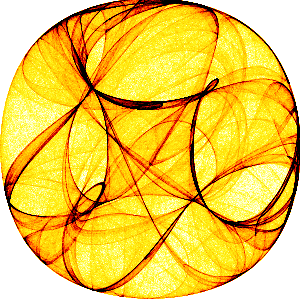

In [14]:
imgfire = applycolormap(attractorGray, firem);
imgfire = colorview(RGB, permuteddimsview(imgfire, (3,1,2)))

In [15]:
function gridmapImg(imggray)
    imgallColorcet = []
    for (indx, colorMap) in enumerate(cmapsColorcet)
        cm = cgrad(colorMap) |> C
        push!(cm, RGBA{Float64}(1, 1 ,1 ,1.0));
        imgRGB = applycolormap(imggray, cm);
        imgRGB = colorview(RGB, permuteddimsview(imgRGB, (3,1,2)))
        push!(imgallColorcet, imgRGB)
    end
    rowimgC = [imgallColorcet[i] for i in 1:length(imgallColorcet)]
    reshape(rowimgC , (2,3))
end

gridmapImg (generic function with 1 method)

,,
,,

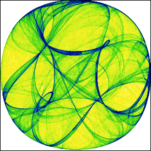
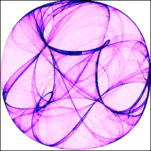
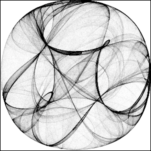
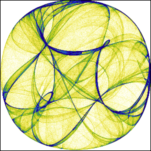
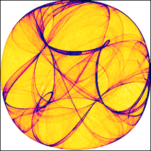
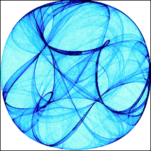

In [16]:
gridmapImg(attractorGray)

Another examples  

In [17]:
x, y = trajectory(clifford, 0.0, 0.0, -1.9, -1.9, -1.9, -1.0, n);

In [18]:
kdcm = cgrad(:kdc) |> C
push!(kdcm, RGBA{Float64}(1, 1 ,1 ,1.0));

In [19]:
attractorGray2 = aggregatePixel(x, y, 300, 300);

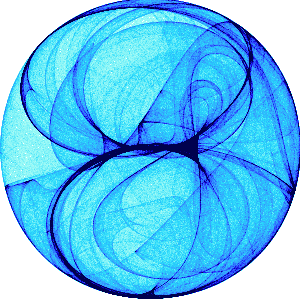

In [20]:
imgkdcm = applycolormap(attractorGray2, kdcm);
imgkdcm = colorview(RGB, permuteddimsview(imgkdcm, (3,1,2)))

In [21]:
save("clifford1.png", imgkdcm)

,,
,,

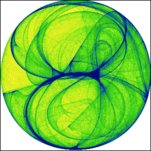
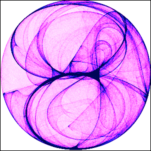
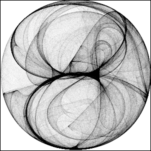
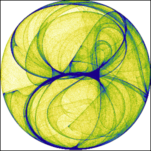
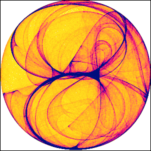
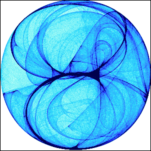

In [22]:
gridmapImg(attractorGray2)

In [23]:
x, y = trajectory(clifford, 0.0, 0.0, 1.7, 1.7, 0.6, 1.2, n);

In [24]:
attractorGray3 = aggregatePixel(x, y, 300, 300);

In [25]:
bmwm = cgrad(:bmw) |> C
push!(bmwm, RGBA{Float64}(1, 1 ,1 ,1.0));

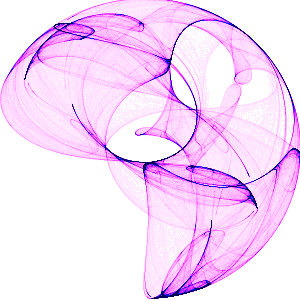

In [26]:
imgbmw = applycolormap(attractorGray3, bmwm);
imgbmw = colorview(RGB, permuteddimsview(imgbmw, (3,1,2)))

In [27]:
save("clifford2.png", imgbmw)

,,
,,

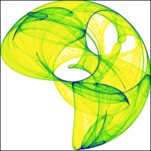
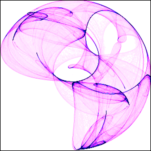
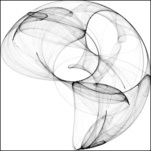
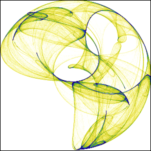
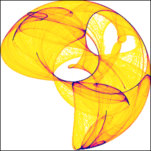
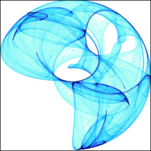

In [28]:
gridmapImg(attractorGray3)

All together... 

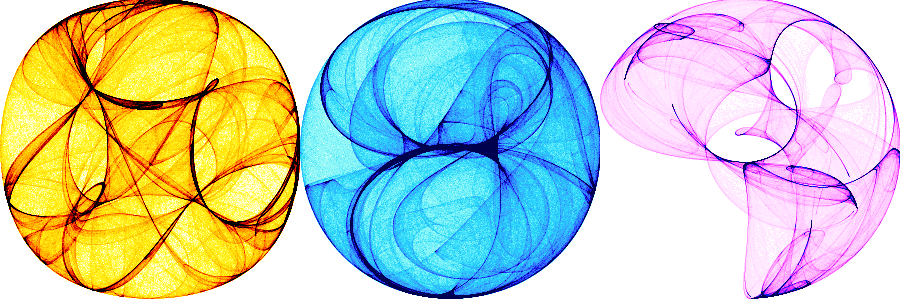

In [29]:
hcat(imgfire, imgkdcm, imgbmw)

A slight modification into the trajectory definition gives astonishing results:

In [30]:
function trajectory(fn, x0::Float64, y0::Float64, a::Float64, b::Float64, c::Float64, d::Float64, 
        dθ::Float64,  n::Int64)
    x, y, θ = zeros(n), zeros(n), 0.01
    x[1], y[1] = x0, y0
    for i = 1:n
        xd, yd = fn(x[i], y[i], a, b, c, d)
        @inbounds x[i+1], y[i+1] = xd*cos(θ), yd*cos(θ)
        θ += dθ
    end
    x, y
end 

trajectory (generic function with 2 methods)

In [31]:
n = 5000000
x, y = trajectory(clifford, 0.0, 0.0, -1.3, -1.3, -1.8, -1.9, 0.007, n);

In [32]:
function aggregatePixel(x, y, w, h, p)
    xpixel = (x .- minimum(x)).*w/(maximum(x) - minimum(x)) .+ 1
    ypixel = (y .- minimum(y)).*h /(maximum(y) - minimum(y)) .+ 1    
    img = zeros(w, h)
    for i = 1:n
        @inbounds begin 
            p0 = (xpixel[i], ypixel[i]) # Let's map to the closest pixel
            idx = Int64.(round.(p0))
            xidx, yidx = idx[1], h - idx[2]
            if checkbounds(Bool, img, xidx, yidx)
                img[yidx, xidx] += 1 # accumulate
            end
        end
    end
    img = img./maximum(img)
    Gray.((clamp.(1 .- p*img, 0, 1)))
end

aggregatePixel (generic function with 2 methods)

In [33]:
attractorGray4 = aggregatePixel(x, y, 300, 300, 500);

In [34]:
kdcm = cgrad(:kdc_r) |> C
push!(kdcm , RGBA{Float64}(0, 0 ,0 ,1.0));

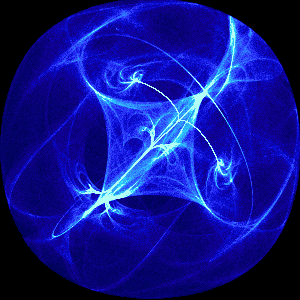

In [35]:
imgt= applycolormap(attractorGray4, kdcm);
imgt= colorview(RGB, permuteddimsview(imgt, (3,1,2)))

In [36]:
save("cliffordCirc.png", imgt)

,,
,,

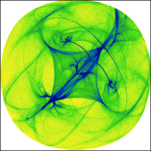
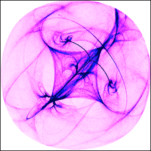
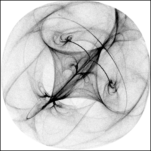
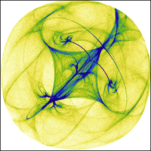
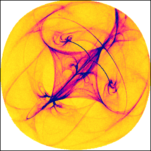
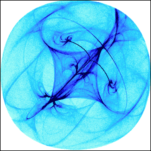

In [37]:
gridmapImg(attractorGray4)

to be continued... maybe.